# Device RB and Purity RB

Perform standard and purity RB on all pairs of the device.

Note this can be lengthy to run on a full 127+ qubit device. Parameters given need to be adjusted depending on the device.

In [1]:
import numpy as np
import rustworkx as rx
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_experiments.framework import (
    ParallelExperiment,
    BatchExperiment,
    ExperimentData,
)

from qiskit_experiments.library import StandardRB
from qiskit_device_benchmarking.bench_code.prb import PurityRB

from qiskit_device_benchmarking.utilities import graph_utils as gu

In [2]:
# enter your device hub/group/project here
# and device

hgp = "ibm-q/open/main"

service = QiskitRuntimeService()
backend_real = service.backend("ibm_kyiv", instance=hgp)
nq = backend_real.configuration().n_qubits
coupling_map = backend_real.configuration().coupling_map

### Use RustworkX and Graph Utilities to Build Sets

Code below uses some of the graph utilities in the package to pull out several sets of isolated two qubit pairs.

In [3]:
# build a set of gates
G = gu.build_sys_graph(nq, coupling_map)
# get all length 2 paths in the device
paths = rx.all_pairs_all_simple_paths(G, 2, 2)
# flatten those paths into a list from the rustwork x iterator
paths = gu.paths_flatten(paths)
# remove permutations
paths = gu.remove_permutations(paths)
# convert to the coupling map of the device
paths = gu.path_to_edges(paths, coupling_map)
# make into separate sets
sep_sets = gu.get_separated_sets(G, paths, min_sep=2)

In [4]:
# rb of all the edges in parallel
rb_batch_list = []
prb_batch_list = []

# RB options
lengths = [1, 10, 20, 50, 100, 150, 250, 400]
num_samples = 5

# also do purity (optional)
# use less samples because we need 9 circuits per length per sample
# also less lengths because they decay faster
do_purity = True
lengths_pur = [1, 5, 10, 25, 50, 100, 175, 250]
num_samples_pur = 3

if "ecr" in backend_real.configuration().basis_gates:
    twoq_gate = "ecr"
elif "cz" in backend_real.configuration().basis_gates:
    twoq_gate = "cz"

# go through for each of the edge sets
for ii in range(len(sep_sets)):
    rb_list = []
    prb_list = []

    for two_i, two_set in enumerate(sep_sets[ii]):
        exp1 = StandardRB(two_set, lengths, num_samples=num_samples)
        rb_list.append(exp1)

    rb_exp_p = ParallelExperiment(rb_list, backend=backend_real, flatten_results=False)
    rb_batch_list.append(rb_exp_p)

    if do_purity:
        for two_i, two_set in enumerate(sep_sets[ii]):
            exp1 = PurityRB(two_set, lengths_pur, num_samples=num_samples_pur)
            prb_list.append(exp1)

        rb_exp_p = ParallelExperiment(
            prb_list, backend=backend_real, flatten_results=False
        )
        prb_batch_list.append(rb_exp_p)

# batch all of them together
# put the purity ones last
full_rb_exp = BatchExperiment(
    rb_batch_list + prb_batch_list, backend=backend_real, flatten_results=False
)
full_rb_exp.set_experiment_options(max_circuits=100)
full_rb_exp.set_run_options(shots=200)

# run
rb_data = full_rb_exp.run()
print(rb_data.job_ids)

6.544245958328247


In [5]:
# Run this cell if you want to reload data from a previous job(s)
if 0:
    # List of job IDs for the experiment
    job_ids = [""]

    rb_data = ExperimentData(experiment=full_rb_exp)
    rb_data.add_jobs([service.job(job_id) for job_id in job_ids])
    full_rb_exp.analysis.run(rb_data, replace_results=True)

    # Block execution of subsequent code until analysis is complete
    rb_data.block_for_results()

### Analyze the Data

First pull all the data into several giant lists. Then plot. Make the jobs have run first which can be probed with `tomo_data.analysis_status()`

In [6]:
rb_data.analysis_status()

<AnalysisStatus.DONE: 'analysis callback has successfully run'>

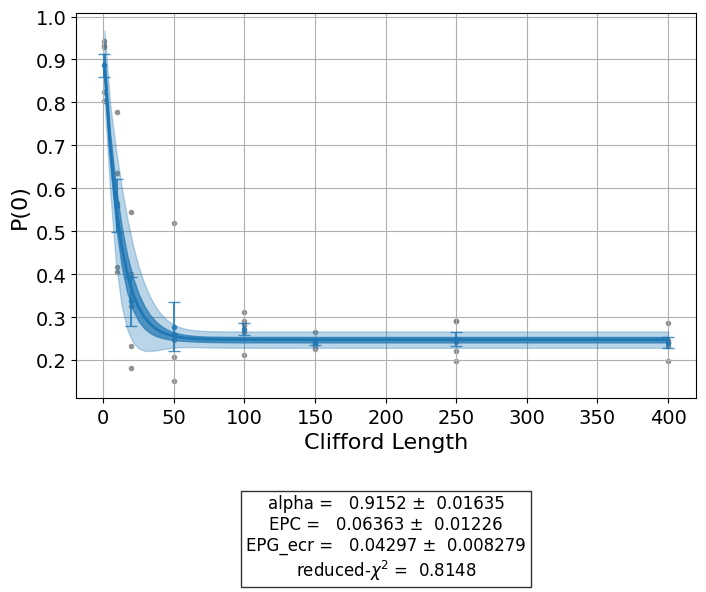

In [11]:
# Plot the data
# Input the edge to plot here
fig_edge = [26, 16]
fig_id = []
for i in range(len(sep_sets)):
    for j in range(len(sep_sets[i])):
        if fig_edge == sep_sets[i][j]:
            fig_id = [i, j]
rb_data.child_data()[fig_id[0]].child_data()[fig_id[1]].figure(0)

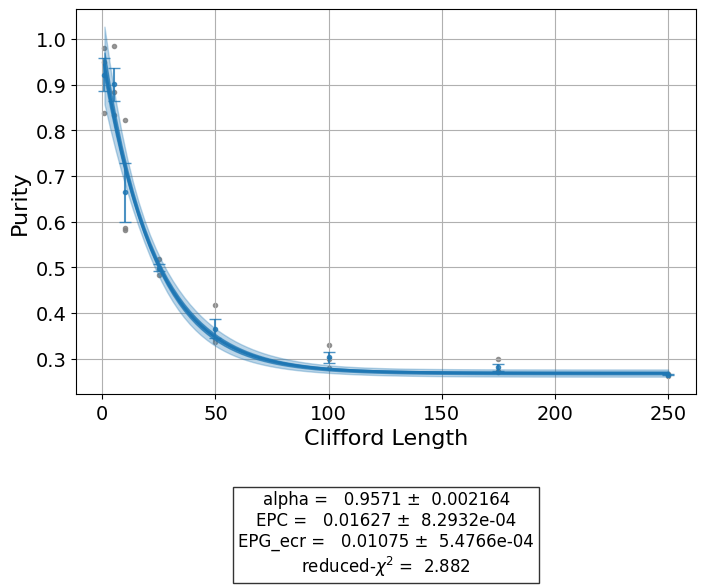

In [12]:
# Plot the PURITY data
# Input the edge to plot here
if not do_purity:
    print("No Purity data was run!")
fig_edge = [26, 16]
fig_id = []
for i in range(len(sep_sets)):
    for j in range(len(sep_sets[i])):
        if fig_edge == sep_sets[i][j]:
            fig_id = [i, j]
rb_data.child_data()[len(sep_sets) + fig_id[0]].child_data()[fig_id[1]].figure(0)

In [ ]:
# Load the RB Error into a list
set_list = []
rb_err = []
pur_rb_err = []
gate_err = []
back_prop = backend_real.properties()
for i in range(len(sep_sets)):
    for j in range(len(sep_sets[i])):
        set_list.append(sep_sets[i][j])
        rb_err.append(
            rb_data.child_data()[i]
            .child_data()[j]
            .analysis_results()[2]
            .value.nominal_value
            / 1.5
        )
        if do_purity:
            # sometimes the purity doesn't fit
            if (
                len(
                    rb_data.child_data()[len(sep_sets) + i]
                    .child_data()[j]
                    .analysis_results()
                )
                == 1
            ):
                pur_rb_err.append(1.0)
            else:
                pur_rb_err.append(
                    rb_data.child_data()[len(sep_sets) + i]
                    .child_data()[j]
                    .analysis_results()[2]
                    .value.nominal_value
                    / 1.5
                )
        gate_err.append(back_prop.gate_error(twoq_gate, set_list[-1]))

        if do_purity:
            print(
                "Q%s, rb error (purity) %.2e (%.2e)/ reported err %.2e"
                % (sep_sets[i][j], rb_err[-1], pur_rb_err[-1], gate_err[-1])
            )
        else:
            print(
                "Q%s, rb error %.2e/ reported err %.2e"
                % (sep_sets[i][j], rb_err[-1], gate_err[-1])
            )

Text(0.5, 1.0, 'Device Gate Errors for ibm_kyiv, job csag66gxgg700086jz90')

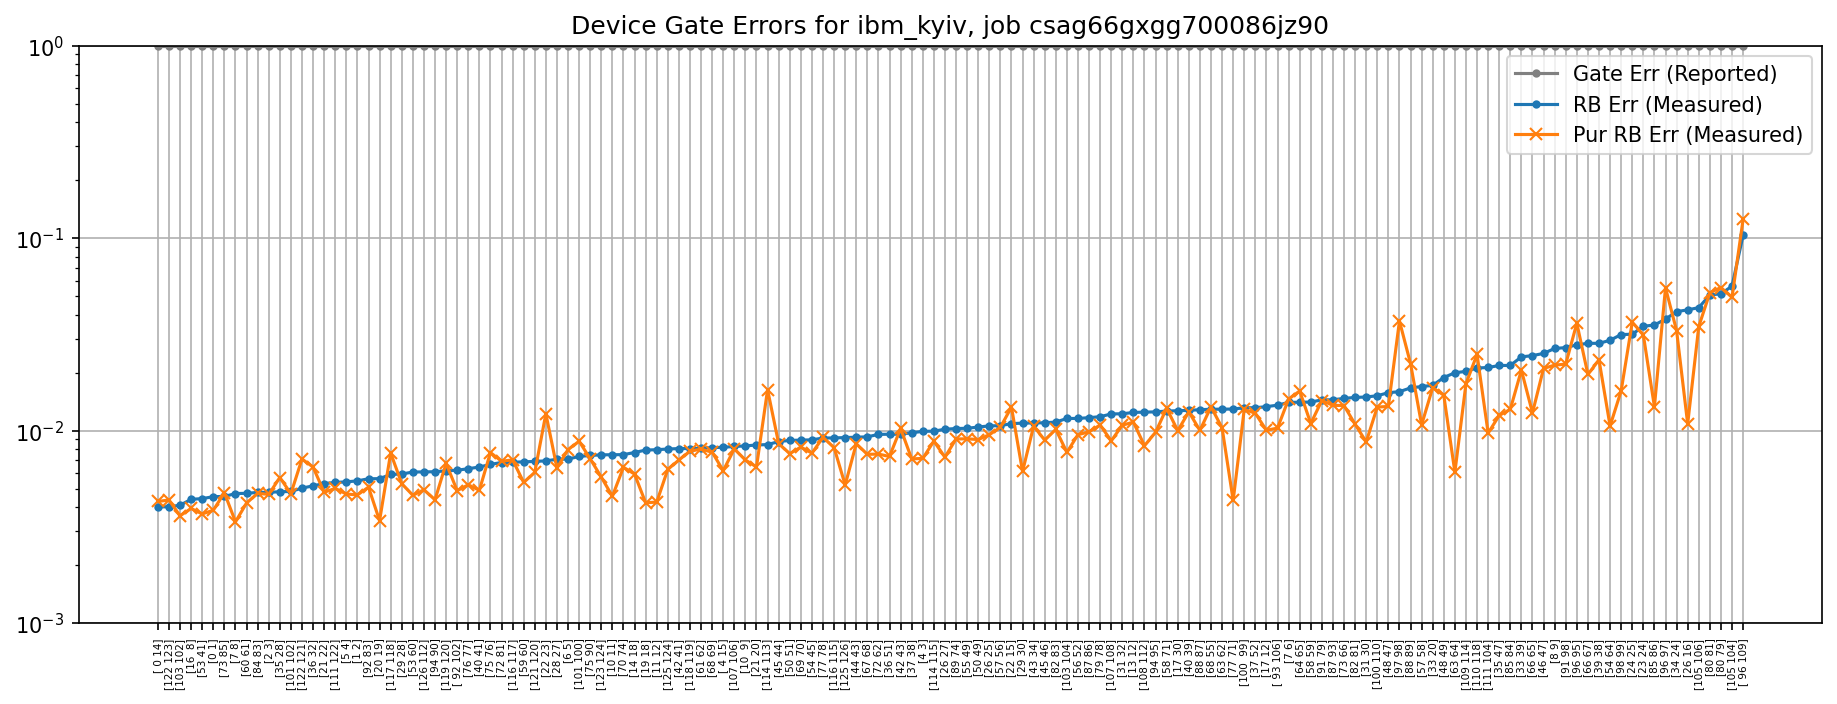

In [8]:
# plot the data ordered by Bell state fidelity (need to run the cell above first)

plt.figure(dpi=150, figsize=[15, 5])
argind = np.argsort(rb_err)
plt.semilogy(
    range(len(set_list)),
    np.array(gate_err)[argind],
    label="Gate Err (Reported)",
    marker=".",
    color="grey",
)
plt.semilogy(
    range(len(set_list)),
    np.array(rb_err)[argind],
    label="RB Err (Measured)",
    marker=".",
)
if do_purity:
    plt.semilogy(
        range(len(set_list)),
        np.array(pur_rb_err)[argind],
        label="Pur RB Err (Measured)",
        marker="x",
    )

plt.xticks(range(len(set_list)), np.array(set_list)[argind], rotation=90, fontsize=5)
plt.ylim([1e-3, 1])
plt.grid(True)
plt.legend()
plt.title("Device Gate Errors for %s, job %s" % (backend_real.name, rb_data.job_ids[0]))

In [54]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += (
        "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    )
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()